# Priestley-Taylor PET calculations

**Last Updated: September 19, 2018**

**Emma Collins**

In this notebook we will calculate PET for Congaree National Park area using Priestly-Taylor equations (1972); thus, the potential evapotranspiration will be guided by the following: 

$$\begin{equation}
PET = \alpha * \frac{\Delta}{\Delta +\gamma}(R_n-G)
\end{equation}$$

where $\Delta$ is the slope of saturation vapor pressure curve at air temperature $T$, $\gamma$ is the psychrometric constant, $R_n$ is net radiation, $G$ si the heat flux transfer to and from the soil, and $\alpha$ is a saturation deficit term.

We will utilize weather station and solar radiation data from the following sources:
- Weather Station:
    - Remote Automated Weather Station (RAWS)
    - Site Name: Congaree
    - Site Code: SCON
    - Station ID: GDNS1
    - Watershed HUC8 : 03050110
    - Lat/Long: 33˚48'54"N, 80˚46'52"W
    - Elevation: 123 ft
- National Solar Radiation Database
    

In [1]:
import pandas as pd
import numpy as np
import sys, os
import json
import requests
import matplotlib.pyplot as plt
import PriestlyTaylorET as PT
import datetime
import time
import matplotlib
import datetime as dt

## Loading the Data

First, we need all data inputs necessary for PET calculations. 

### Extraterrestrial Solar Radiation Data download

Using the NREL National Solar Radiation Database API

In [2]:
# Define the lat, long of the location and the year
lat, lon, year = 33.814722, -80.781111, 2009

# Signup for one here: https://developer.nrel.gov/signup/
api_key = '****'

# Set the attributes to extract (e.g., dhi, ghi, etc.), separated by commas.
attributes = 'ghi'

# Choose year of data
year = '2009'

# Set leap year to true or false. True will return leap day data if present, false will not.
leap_year = 'false'

# Set time interval in minutes, i.e., '30' is half hour intervals. Valid intervals are 30 & 60.
interval = '60'

# Specify Coordinated Universal Time (UTC), 'true' will use UTC, 'false' will use the local time zone of the data.
# NOTE: In order to use the NSRDB data in SAM, you must specify UTC as 'false'. SAM requires the data to be in the
# local time zone.
utc = 'false'

# Your full name, use '+' instead of spaces.
your_name = 'Emma+Collins'

# Your reason for using the NSRDB.
reason_for_use = 'research'

# Your affiliation
your_affiliation = 'College+of+Charleston'

# Your email address
your_email = 'collinsel2@g.cofc.edu'

# Please join our mailing list so we can keep you up-to-date on new developments.
mailing_list = 'true'

# Declare url string
url = 'http://developer.nrel.gov/api/solar/nsrdb_0512_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
# Return just the first 2 lines to get metadata:
info = pd.read_csv(url, nrows=1)

# See metadata for specified properties, e.g., timezone and elevation
timezone, elevation = info['Local Time Zone'], info['Elevation']

We will save the extraterrestrial solar radiation in a dataframe. I've selected GHI as the parameter to download from the database. GHI stands for Global Horizontal Irradiance, which is defined as:
- "the total amount of shortwave radiation received from above by a horizontal surface. This value is of particular interest to photovoltaic installations and includes both Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DIF)." (https://www.3tier.com/en/support/glossary/#ghi)

In [3]:
# Return all but first 2 lines of csv to get data:rn all  
GHI_df = pd.read_csv('http://developer.nrel.gov/api/solar/nsrdb_0512_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes), skiprows=2)

# Set the time index in the pandas dataframe:
GHI_df = GHI_df.set_index(pd.date_range('1/1/{yr}'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))

In [4]:
#To save the data as a .csv file
#df.loc['2009-6-1':'2009-7-31'].to_csv(path_or_buf='GHI_JuneJuly_2009.csv')

#Subset the dataframe of solar radiation data to June and July of 2009
GHI_df = GHI_df.loc['2009-6-1':'2009-7-31']

#Make date/time its own column
GHI_df.index.name = 'DateTime'
GHI_df.reset_index(inplace=True)

In [5]:
#Preview the data
GHI_df.head()

,DateTime,Year,Month,Day,Hour,Minute,GHI
0,2009-06-01 00:00:00,2009,6,1,0,30,0
1,2009-06-01 01:00:00,2009,6,1,1,30,0
2,2009-06-01 02:00:00,2009,6,1,2,30,0
3,2009-06-01 03:00:00,2009,6,1,3,30,0
4,2009-06-01 04:00:00,2009,6,1,4,30,0


## Accessing Weather Station Data

Using MesoWest API for Congaree Weather Station GDNS1

In [6]:
#Signup for a key here: https://synopticlabs.org/api/signup/
api_token = '****'

#Base Url
api_url = 'http://api.mesowest.net/v2/stations/timeseries'

#Enter start and end time as 'yyyymmddHHMM'
start_time = '200906010400'
end_time = '200908010400'

#Set parameters for API request
parameters = {"start": start_time, "end": end_time,"precip":'1',"timeformat":'%Y-%m-%d %H:%M', "complete":'0', "obtimezone":'local', "stid":'GDNS1', "state":'sc', "output":'JSON',"vars":'fuel_temp,solar_radiation,air_temp,relative_humidity,fuel_moisture, precip_accum',"token":api_token}

#Access API
response = requests.get(api_url, params=parameters)

In [7]:
#Convert to JSON object
weather = response.json()

#Store observations as numpy arrays, note observations are hourly
date_time = np.array(weather['STATION'][0]['OBSERVATIONS']['date_time'])
solar_radiation = np.array(weather['STATION'][0]['OBSERVATIONS']['solar_radiation_set_1'])
fuel_temp = np.array(weather['STATION'][0]['OBSERVATIONS']['fuel_temp_set_1'])
relative_humidity = np.array(weather['STATION'][0]['OBSERVATIONS']['relative_humidity_set_1'])
fuel_moisture = np.array(weather['STATION'][0]['OBSERVATIONS']['fuel_moisture_set_1'])
air_temp = np.array(weather['STATION'][0]['OBSERVATIONS']['air_temp_set_1'])
precip_accum = np.array(weather['STATION'][0]['OBSERVATIONS']['precip_accumulated_set_1d'])
                                              

To handle the missing data issue, we will ensure that we only keep weather station and solar radiation data points when both are available.

Note: This is the largest computational cost of the program, and discards potentially many data points. Should we use interpolation methods to fill in missing data? 

In [8]:
GHI_ind = []
weather_ind = []
for i in range(len(GHI_df.iloc[:,0])):
    for j in range(len(date_time)):
        if np.datetime64(GHI_df.iloc[i,0])== np.datetime64(date_time[j][0:13]):
            if relative_humidity[j] and solar_radiation[j] and fuel_temp[j] and fuel_moisture[j] and air_temp[j]:
                GHI_ind.append(i)
                weather_ind.append(j)

In [9]:
GHI_daily = GHI_df.iloc[GHI_ind].groupby(['Year','Month', 'Day']).agg({'GHI':'sum'})
GHI_daily.head()

GHI
Year Month Day      
2009 6     10   2043
           11   3696
           12   6130
           13   6766
           14   6505

In [10]:
date_time = date_time[weather_ind]
solar_radiation = solar_radiation[weather_ind]
fuel_temp = fuel_temp[weather_ind]
relative_humidity = relative_humidity[weather_ind]
fuel_moisture = fuel_moisture[weather_ind]
air_temp = air_temp[weather_ind]

In [11]:
weather_station = pd.DataFrame(weather['STATION'][0]['OBSERVATIONS'])
weather_station['date_time'] = pd.to_datetime(weather_station['date_time'], format = '%Y-%m-%d %H:%M')
weather_station['date_time'] = weather_station['date_time'].dt.floor('d')
weather_station_daily = weather_station.groupby(['date_time']).agg({'air_temp_set_1':'mean','fuel_moisture_set_1':'mean', 'fuel_temp_set_1':'mean', 'relative_humidity_set_1':'mean', 'solar_radiation_set_1':'sum'})
weather_station_daily = weather_station_daily.dropna(how = 'any')
weather_station_daily.head()


,air_temp_set_1,fuel_moisture_set_1,fuel_temp_set_1,relative_humidity_set_1,solar_radiation_set_1
date_time,,,,,
2009-06-10,24.977500,20.183333,26.481250,78.818182,5494.0
2009-06-11,23.797083,21.916667,25.255417,84.157895,4829.0
2009-06-12,24.258750,22.470833,25.623750,87.166667,4902.0
2009-06-13,25.810417,18.954167,27.570000,82.208333,5667.0
2009-06-14,26.064167,16.883333,28.264583,80.125000,5484.0


In [12]:
GHI_daily.head()

GHI
Year Month Day      
2009 6     10   2043
           11   3696
           12   6130
           13   6766
           14   6505

### Converting from Solar Radiation To Net Radiation

albedo (REF)

$a_c$, $b_c$ (REF, FAO 1990)

In [13]:
#For a coniferous/deciduous forest, albedo is set at 0.15
albedo = 0.15

#extraterrestrial solar radiation
Ra = np.asarray(GHI_daily)

#Convert from W/m**2 to MJ/m**2/d
Ra = Ra*0.0864
solar_radiation = np.asarray(weather_station_daily['solar_radiation_set_1'])
solar_radiation = solar_radiation*0.0864

#Elevation of weather station(m)
elevation_ft = np.float(weather['STATION'][0]['ELEVATION'])
elevation = elevation_ft*.3048

#Daily Air Temp
air_temp_daily = np.asarray(weather_station_daily['air_temp_set_1'])

#Daily Relative Humidity
relative_humidity_daily = np.asarray(weather_station_daily['relative_humidity_set_1'])

fuel_temp_daily = np.asarray(weather_station_daily['fuel_temp_set_1'])

fuel_moisture_daily = np.asarray(weather_station_daily['fuel_moisture_set_1'])

### Priestley-Taylor PET calculations

Implementing Priestly Taylor for Congaree NP

In [14]:
evapotranspiration = PT.PET(air_temp_daily, fuel_temp_daily, elevation,relative_humidity_daily, fuel_moisture_daily, solar_radiation, Ra, albedo)

#convert from MJ/m**2/day to mm/day
evapotranspiration = evapotranspiration/2.45


Text(0.5,0,'Date')

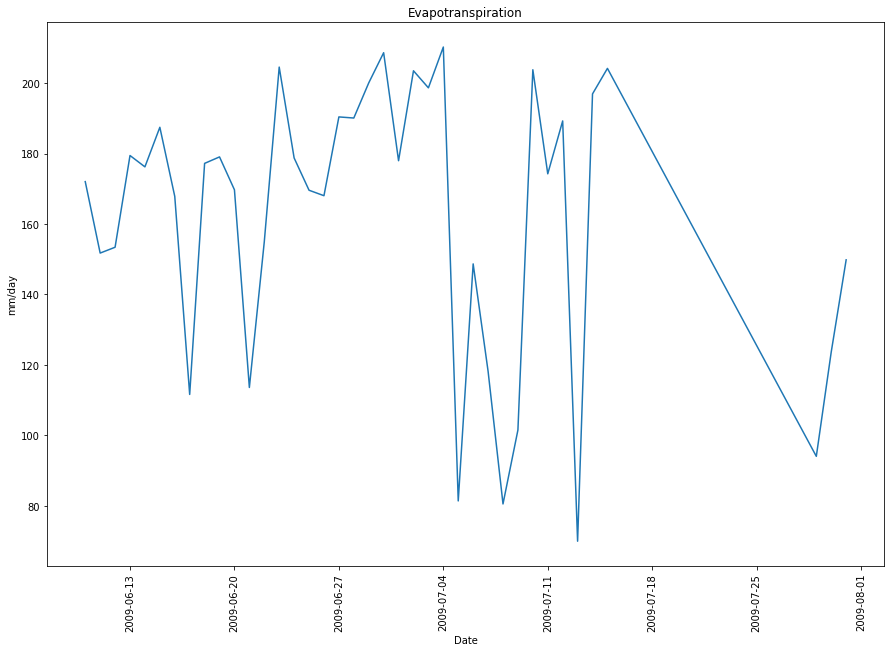

In [15]:
dates = []
for i in range(len(date_time)):
    h = datetime.datetime.strptime(date_time[i], "%Y-%m-%d %H:%M")
    dates.append(datetime.datetime.date(h))
dates = sorted(list(set(dates)))
dates_plot = matplotlib.dates.date2num(dates)
plt.figure(figsize = (15,10))
plt.plot_date(dates_plot, np.asarray(evapotranspiration),'-', ydate = False)
plt.title("Evapotranspiration")
plt.xticks(rotation = 'vertical')
plt.ylabel('mm/day')
plt.xlabel('Date')

In [16]:
ET = pd.DataFrame(evapotranspiration, columns = {'PET (mm)'})
date = pd.DataFrame(dates, columns = {'Date'})
table = pd.concat([date, ET], axis=1)

### Results:

The final product of the calculations, a table of PET in mm by day. 

In [17]:
print(table)

          Date    PET (mm)
0   2009-06-10  172.027980
1   2009-06-11  151.739771
2   2009-06-12  153.393715
3   2009-06-13  179.441445
4   2009-06-14  176.220550
5   2009-06-15  187.459973
6   2009-06-16  167.836115
7   2009-06-17  111.596687
8   2009-06-18  177.207333
9   2009-06-19  179.047043
10  2009-06-20  169.707196
11  2009-06-21  113.573831
12  2009-06-22  154.941933
13  2009-06-23  204.549766
14  2009-06-24  178.752090
15  2009-06-25  169.581915
16  2009-06-26  168.029172
17  2009-06-27  190.401913
18  2009-06-28  190.088410
19  2009-06-29  200.053239
20  2009-06-30  208.634059
21  2009-07-01  177.967797
22  2009-07-02  203.501956
23  2009-07-03  198.658479
24  2009-07-04  210.245503
25  2009-07-05   81.360230
26  2009-07-06  148.665686
27  2009-07-07  118.197137
28  2009-07-08   80.500184
29  2009-07-09  101.497511
30  2009-07-10  203.796999
31  2009-07-11  174.246568
32  2009-07-12  189.260929
33  2009-07-13   69.918777
34  2009-07-14  196.933903
35  2009-07-15  204.185001
3

## Questions:
- I used the GHI parameter from the NSRDB as an estimate for extraterrestrial solar radiation, is there a way to improve upon this? 
    - **Extraterrestrial Solar Radiation:** the intensity (power) of the sun at the top of the Earth's atmosphere. It is usually expressed in irradiance units (Watts per square meter) on a plane normal to the sun
    - **Global Horizontal Irradiance (GHI):** the total amount of shortwave radiation received from above by a surface horizontal to the ground.